## **Project: Maternal health risk prediction using machine learning**
- **Source**: Ahmed, M. et al (2020). Review and Analysis of Risk Factor of Maternal Health in Remote Area Using the Internet of Things (IoT). Conference paper InECCE2019 Lecture Notes in Electrical Engineering ((LNEE,volume 632))
- **Date**: 15/01/24
- **Goal**: Create a basic prediction model and a feature explainer

In [ ]:
# Step 0. Load libraries and custom modules
# Basic ----------------------------------------------------------------
import logging
import pickle
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    LabelEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay,
    DetCurveDisplay
)
from sklearn.inspection import permutation_importance  
import shap
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
df_raw = pd.read_csv('../../data/maternal_health_risk.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [3]:
df_raw.sample(10, random_state=2024)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
801,23,130,70,6.80,98.0,78,mid risk
126,54,140,100,15.00,98.0,66,high risk
683,40,140,100,18.00,98.0,90,high risk
733,18,120,80,6.90,102.0,76,mid risk
69,32,120,65,6.00,101.0,76,mid risk
251,12,95,60,6.90,98.0,65,low risk
944,35,100,70,7.50,98.0,66,low risk
709,20,120,75,7.01,100.0,70,mid risk
163,21,120,80,7.50,98.0,76,low risk
297,42,120,80,7.70,98.0,70,low risk


### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking['risklevel'] = df_baking['risklevel'].astype('category')
df_baking['heartrate'] = df_baking['heartrate'].apply(
    lambda x: 76 if x<50 else x
)
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          1014 non-null   int64   
 1   systolicbp   1014 non-null   int64   
 2   diastolicbp  1014 non-null   int64   
 3   bs           1014 non-null   float64 
 4   bodytemp     1014 non-null   float64 
 5   heartrate    1014 non-null   int64   
 6   risklevel    1014 non-null   category
dtypes: category(1), float64(2), int64(4)
memory usage: 48.8 KB


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [5]:
df_train, df_test = train_test_split(
    df, test_size=0.2,
    stratify=df['risklevel'],
    random_state=2025
)
df_train, df_val = train_test_split(
    df_train, test_size=0.20,
    stratify=df_train['risklevel'],
    random_state=2025
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((648, 7), (163, 7), (203, 7))

In [6]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
age,648.0,29.859568,13.590740,10.0,19.0,25.0,37.00,66.0
systolicbp,648.0,112.958333,18.548482,70.0,98.0,120.0,120.00,160.0
diastolicbp,648.0,76.179012,13.723322,49.0,65.0,80.0,89.25,100.0
bs,648.0,8.773657,3.313049,6.0,6.9,7.5,8.00,19.0
bodytemp,648.0,98.670370,1.381301,98.0,98.0,98.0,98.00,103.0
heartrate,648.0,74.237654,7.517872,60.0,70.0,76.0,80.00,90.0


,count,unique,top,freq
risklevel,648,3,low risk,260


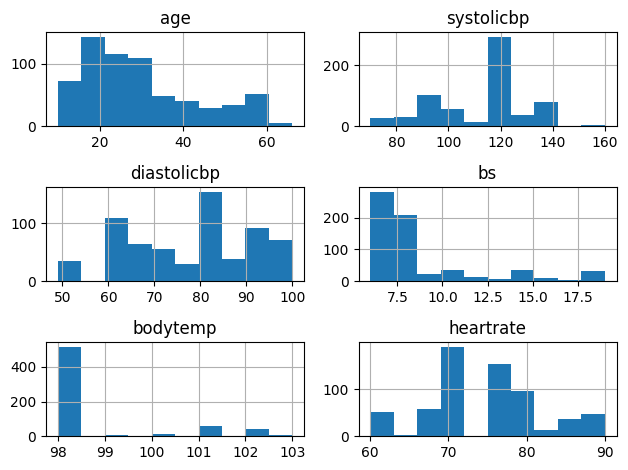

In [7]:
df_train.hist()
plt.tight_layout()
plt.show()

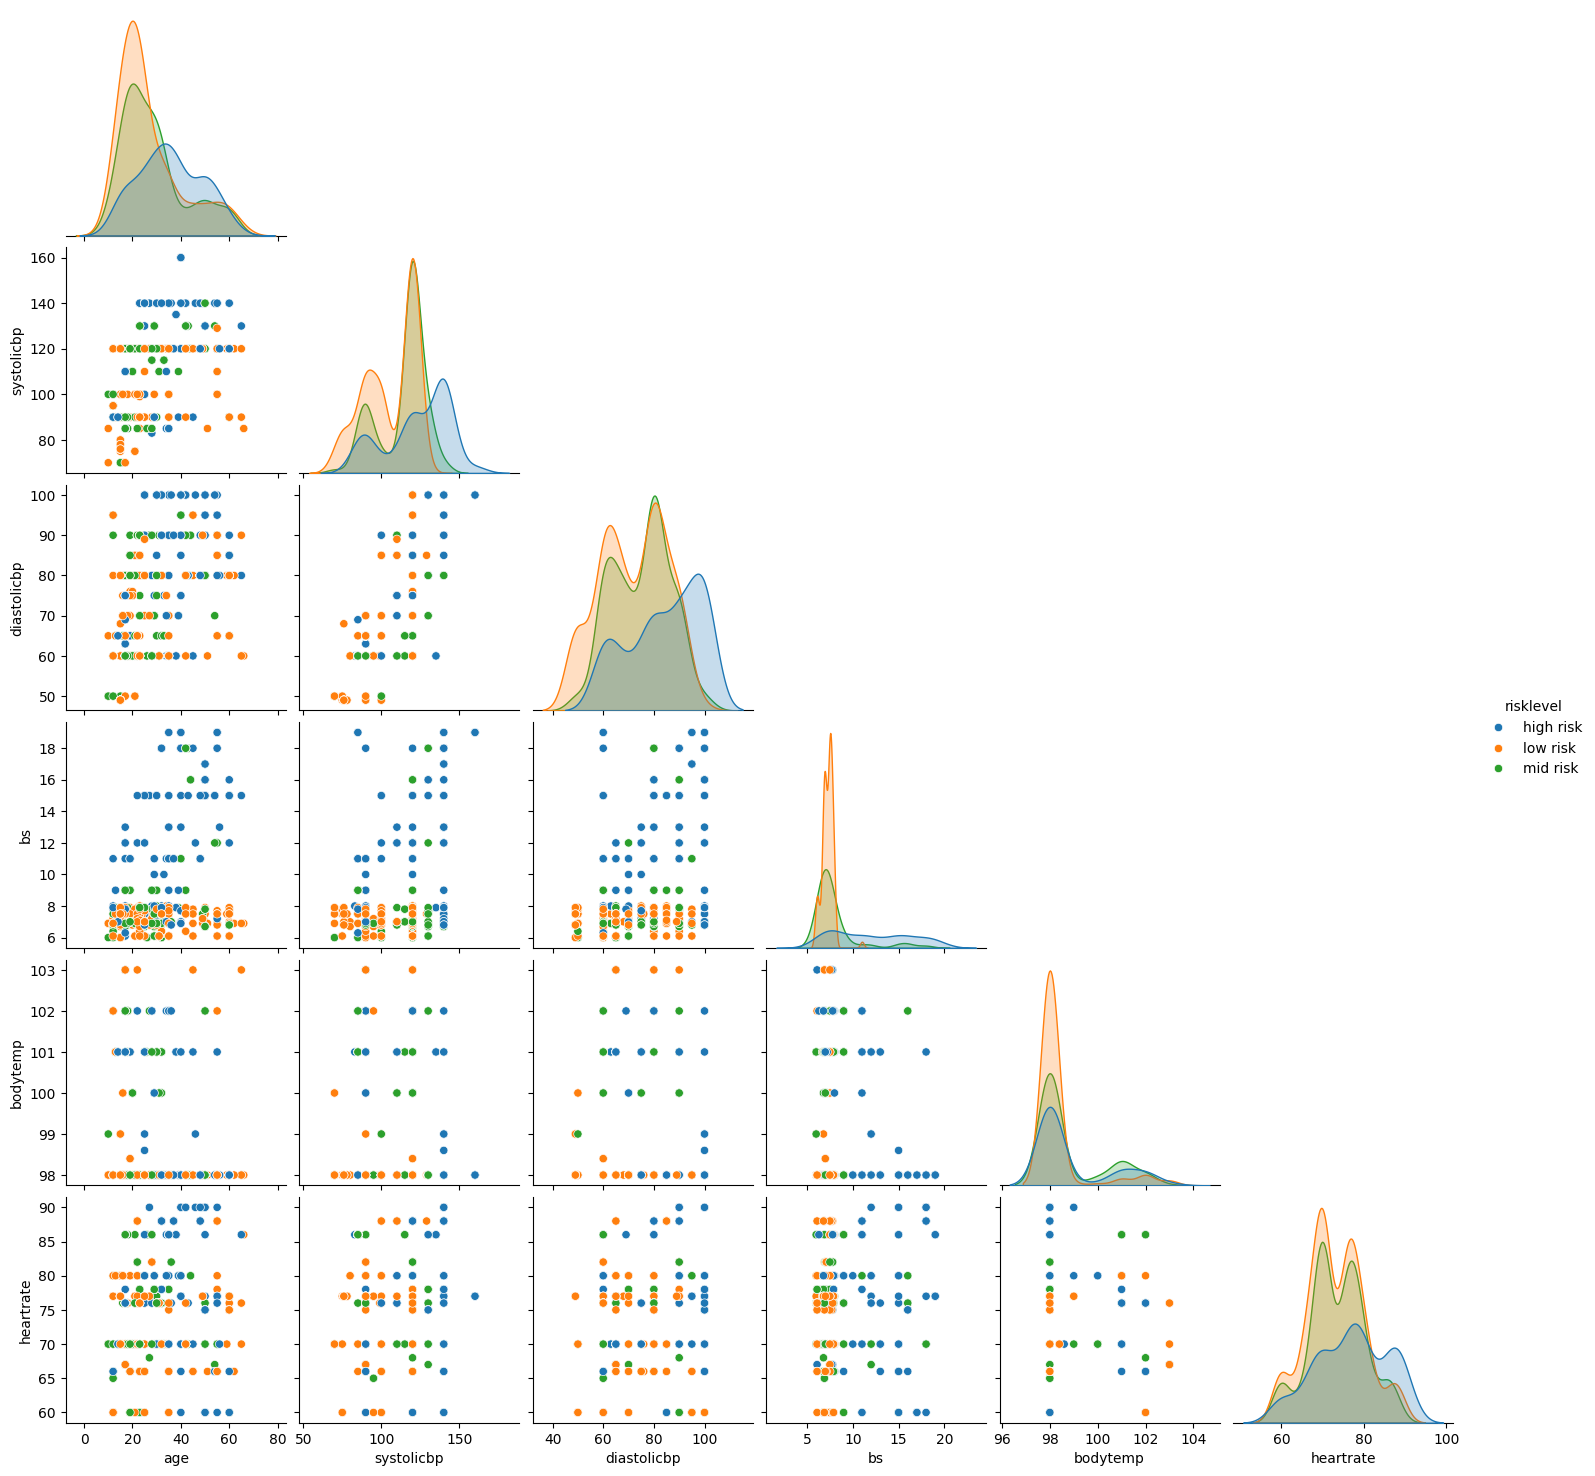

In [8]:
sns.pairplot(df_train, hue='risklevel', corner=True)
plt.show()

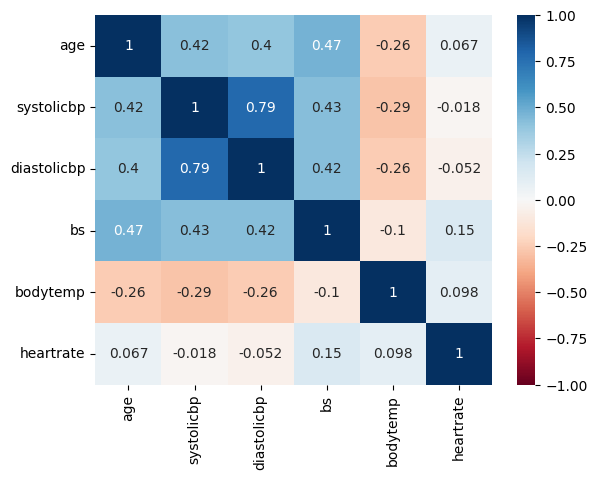

In [9]:
sns.heatmap(
    df.drop(columns=['risklevel']).corr(), 
    vmin=-1, vmax=1, annot=True, cmap='RdBu'
)
plt.show()

### **4. Machine learning**
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [10]:
X_train = df_train.drop('risklevel', axis=1)
y_train = df_train['risklevel']
X_val = df_val.drop('risklevel', axis=1)
y_val = df_val['risklevel']
X_test = df_test.drop('risklevel', axis=1)
y_test = df_test['risklevel']

In [11]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [12]:
clf_rforest_p = Pipeline([
    ('scaler', StandardScaler()),
    ('rforest', RandomForestClassifier(class_weight='balanced', random_state=2024))
])

In [13]:
clf_rforest_p.fit(X_train, y_train)
print(clf_rforest_p['rforest'].get_params())
print(f'Aparent accuracy: {clf_rforest_p.score(X_val, y_val):.2f}')


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2024, 'verbose': 0, 'warm_start': False}
Aparent accuracy: 0.86


In [14]:
clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid={
        'rforest__n_estimators': [25, 50, 100, 150, 200],
        'rforest__max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15],
        'rforest__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'rforest__min_samples_leaf': [1, 2, 4, 6],
    },
    cv=10,
    scoring='f1_weighted',
    n_jobs=4
)

In [15]:
clf_rforest_cv.fit(X_train, y_train_enc)
clf_rforest_cv.best_params_

{'rforest__max_depth': 15,
 'rforest__min_samples_leaf': 1,
 'rforest__min_samples_split': 2,
 'rforest__n_estimators': 150}

In [25]:
y_hat_val = clf_rforest_cv.best_estimator_.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val_enc, y_hat_val):.2f}')
print(f"F1 Score: {f1_score(y_val_enc, y_hat_val, average='weighted'):.2f}")
print(f'Matthews Coef.: {matthews_corrcoef(y_val_enc, y_hat_val):.2f}')

Accuracy: 0.85
F1 Score: 0.85
Matthews Coef.: 0.77


Accuracy: 0.88
F1 Score: 0.88
Matthews Coef.: 0.82
              precision    recall  f1-score   support

   high risk       0.93      0.93      0.93        44
    low risk       0.82      0.85      0.83        65
    mid risk       0.81      0.78      0.79        54

    accuracy                           0.85       163
   macro avg       0.85      0.85      0.85       163
weighted avg       0.85      0.85      0.85       163



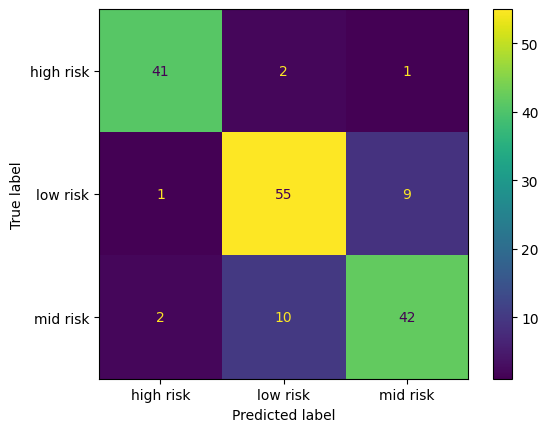

In [26]:
from sklearn.metrics import classification_report
y_hat_test = clf_rforest_cv.best_estimator_.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat_test):.2f}')
print(f"F1 Score: {f1_score(y_test_enc, y_hat_test, average='weighted'):.2f}")
print(f'Matthews Coef.: {matthews_corrcoef(y_test_enc, y_hat_test):.2f}')
print(classification_report(y_val_enc, y_hat_val, target_names=label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_val_enc, y_hat_val, display_labels=label_encoder.classes_)
plt.show()

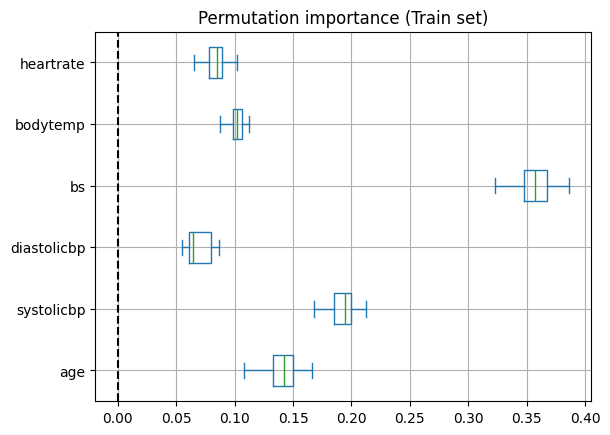

In [29]:
importance = permutation_importance(
    clf_rforest_cv, X_train, y_train_enc, 
    n_repeats=25, random_state=2024
)
importance_df = pd.DataFrame(
    importance.importances.T, columns=X_train.columns
)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--')
ax.set_title('Permutation importance (Train set)')
ax.grid(True)
plt.show()

In [49]:
X_encoded = clf_rforest_cv.best_estimator_['scaler'].transform(X_train)
best_model = clf_rforest_cv.best_estimator_['rforest'].fit(
    X_encoded, y_train_enc
)
shap_values = shap.TreeExplainer(best_model).shap_values(
    pd.DataFrame(X_encoded, columns=X_train.columns.to_list())
)

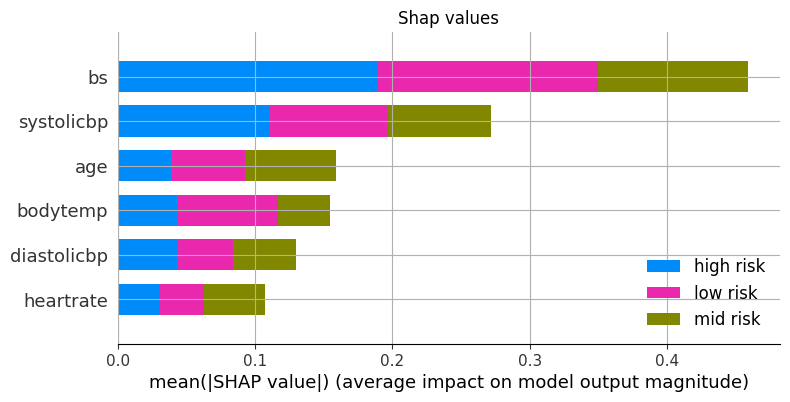

In [53]:
plt.figure()
shap.summary_plot(
    shap_values, pd.DataFrame(X_encoded,columns=X_train.columns.to_list()), 
    plot_type='bar', show=False, class_names=label_encoder.classes_)
plt.title('Shap values')
plt.grid(True)
plt.show()

### **5. Model saving**
**Objective**: Save the model and some critical information we consider necessary